### EDA & Data Cleansing

- Reference: https://www.kaggle.com/code/jagangupta/stop-the-s-toxic-comments-eda
- Used the resource above as a baseline + Modified it so that it is compatiable with latest versions
- In case of NLTK errors: <python -m nltk.downloader wordnet>

## Install required packages

In [1]:
!pip install -q -U "tensorflow-text==2.8.*"
!pip install -q tf-models-official==2.7.0

     |████████████████████████████████| 4.9 MB 7.4 MB/s 
     |████████████████████████████████| 497.9 MB 36 kB/s 
     |████████████████████████████████| 462 kB 69.4 MB/s 
     |████████████████████████████████| 1.4 MB 53.7 MB/s 
     |████████████████████████████████| 5.8 MB 37.2 MB/s 
     |████████████████████████████████| 1.8 MB 6.3 MB/s 
     |████████████████████████████████| 1.3 MB 51.5 MB/s 
     |████████████████████████████████| 238 kB 72.9 MB/s 
     |████████████████████████████████| 43 kB 2.2 MB/s 
     |████████████████████████████████| 352 kB 61.7 MB/s 
     |████████████████████████████████| 118 kB 67.5 MB/s 
     |████████████████████████████████| 1.1 MB 63.4 MB/s 


In [2]:
from google.colab import drive
drive.mount("/content/drive")
import os
import sys
sys.path.append("/drive/MyDrive/CS7641ML_teamproject")
path = "./drive/MyDrive/CS7641ML_teamproject/jigsaw-toxic-comment-classification-challenge/"

Mounted at /content/drive


In [3]:
# !pwd

In [4]:
!python -m nltk.downloader stopwords

/usr/lib/python3.7/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
import pandas as pd 
import numpy as np
import seaborn as sns

import gc
import time
import warnings

from imageio import imread
from scipy import sparse
import scipy.stats as ss

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import seaborn as sns
# from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import matplotlib_venn as venn

import string
import re
import nltk
from nltk.corpus import stopwords
import spacy
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer   

import tensorflow as tf
import tensorflow_hub as hub
# import tensorflow_text as text
# from official.nlp import optimization  # to create AdamW optimizer

from sklearn import metrics
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score

tf.get_logger().setLevel('ERROR')

start_time=time.time()
color = sns.color_palette()
sns.set_style("dark")
eng_stopwords = set(stopwords.words("english"))
warnings.filterwarnings("ignore")

lem = WordNetLemmatizer()
tokenizer=TweetTokenizer()

%matplotlib inline

## Part 1 : Import Data

In [6]:
train=pd.read_csv(path + "train.csv")
test=pd.read_csv(path + "test.csv")
test_label = pd.read_csv(path + 'test_labels.csv')

train.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [7]:
train.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


## Part2 : EDA

- The dataset is biased (non-toxic > toxic)
- Some text have multiple tags

In [8]:
n_train = train.shape[0]
n_test = test.shape[0]
n_total = n_train + n_test
print("       | Train | Test")
print("count  :",n_train,":",n_test)
print("ratio  :", round(n_train * 100 / n_total),"   :",round(n_test * 100 / n_total))

       | Train | Test
count  : 159571 : 153164
ratio  : 51    : 49


In [9]:
x = train.iloc[:, 2:].sum()
train['non-toxic'] = (train.iloc[:,2:].sum(axis=1)==0)
print("Total : ", len(train))
print("Total non-toxic comments : ", train['non-toxic'].sum())
print("Total labels : ", x.sum())

Total :  159571
Total non-toxic comments :  143346
Total labels :  35098


In [10]:
print('Check Null Values: ')
print(train.isnull().sum())

Check Null Values: 
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
non-toxic        0
dtype: int64


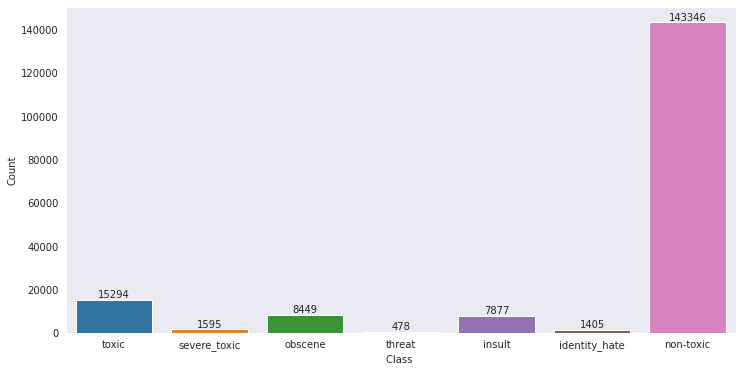

In [11]:
x = train.iloc[:,2:].sum()
plt.figure(figsize=(12,6))
ax = sns.barplot(x = x.index, y = x.values)
plt.ylabel('Count', fontsize=10)
plt.xlabel('Class ', fontsize=10)
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
plt.show()

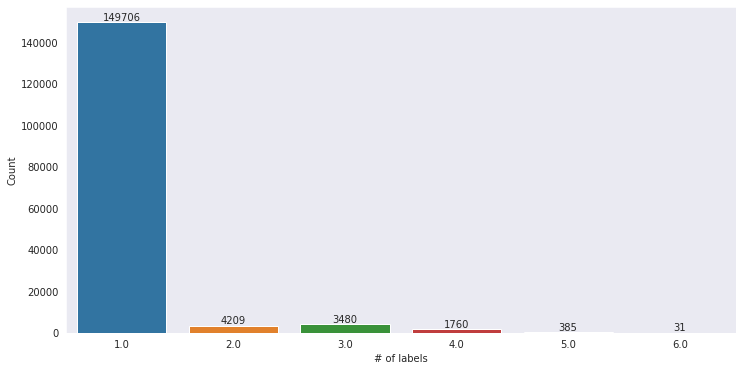

In [12]:
x = train.iloc[:,2:].sum(axis=1).value_counts()

plt.figure(figsize=(12,6))
ax = sns.barplot(x = x.index, y = x.values)
plt.ylabel('Count', fontsize=10)
plt.xlabel('# of labels', fontsize=10)

rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

### Some datapoints have multiple tags.

In [13]:
temp_df = train.iloc[:,2:-1]
mats = []
for col in temp_df.columns[1:]:
    mat = pd.crosstab(temp_df["toxic"], temp_df[col])
    mats.append(mat)
mats = pd.concat(mats, axis=1, keys=temp_df.columns[1:])
mats

severe_toxic       obscene        threat       insult        \
severe_toxic            0     1       0     1       0    1       0     1   
toxic                                                                      
0                  144277     0  143754   523  144248   29  143744   533   
1                   13699  1595    7368  7926   14845  449    7950  7344   

             identity_hate        
severe_toxic             0     1  
toxic                             
0                   144174   103  
1                    13992  1302

### Seems like toxic=0 even if a comment is obscene/threat/...
### Maybe we should apply toxic=1 if a comment is obscene/threat/...

In [14]:
train.loc[(train['severe_toxic']==1) | (train['obscene']==1) | (train['threat']==1) | (train['insult']==1) | (train['identity_hate']==1), 'toxic']=1

In [15]:
temp_df = train.iloc[:,2:-1]
mats = []
for col in temp_df.columns[1:]:
    mat = pd.crosstab(temp_df["toxic"], temp_df[col])
    mats.append(mat)
mats = pd.concat(mats, axis=1, keys=temp_df.columns[1:])
mats

severe_toxic       obscene        threat       insult        \
severe_toxic            0     1       0     1       0    1       0     1   
toxic                                                                      
0                  143346     0  143346     0  143346    0  143346     0   
1                   14630  1595    7776  8449   15747  478    8348  7877   

             identity_hate        
severe_toxic             0     1  
toxic                             
0                   143346     0  
1                    14820  1405

In [16]:
print("toxic:")
print(train[train.severe_toxic==1].iloc[3,1])

toxic:
Hi 

Im a fucking bitch.

50.180.208.181


In [17]:
print("severe_toxic:")
print(train[train.severe_toxic==1].iloc[4,1])

severe_toxic:
What a motherfucking piece of crap those fuckheads for blocking us!


In [18]:
print("Threat:")
print(train[train.threat==1].iloc[1,1])

Threat:
I think that your a Fagget get a oife and burn in Hell I hate you 'm sorry we cant have any more sex i'm running out of conndoms


In [19]:
print("Obscene:")
print(train[train.obscene==1].iloc[1,1])

Obscene:
You are gay or antisemmitian? 

Archangel WHite Tiger

Meow! Greetingshhh!

Uh, there are two ways, why you do erased my comment about WW2, that holocaust was brutally slaying of Jews and not gays/Gypsys/Slavs/anyone...

1 - If you are anti-semitian, than shave your head bald and go to the skinhead meetings!

2 - If you doubt words of the Bible, that homosexuality is a deadly sin, make a pentagram tatoo on your forehead go to the satanistic masses with your gay pals!

3 - First and last warning, you fucking gay - I won't appreciate if any more nazi shwain would write in my page! I don't wish to talk to you anymore!

Beware of the Dark Side!


In [20]:
print("identity_hate:")
print(train[train.identity_hate==1].iloc[4,1])

identity_hate:
u r a tw@ fuck off u gay boy.U r smelly.Fuck ur mum poopie


In [21]:
train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.101679,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.302226,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [22]:
cols = ['obscene', 'insult', 'toxic', 'severe_toxic', 'identity_hate', 'threat']
print(train[cols].sum())

obscene           8449
insult            7877
toxic            16225
severe_toxic      1595
identity_hate     1405
threat             478
dtype: int64


- Most of the text length are within 500 characters, with some up to 5,000 characters long.

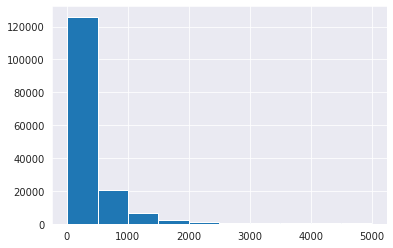

In [23]:
train['length'] = train['comment_text'].apply(lambda x: len(str(x)))
train['length'].hist()
plt.show()

In [24]:
# ==================================
# ==================================

## Part3 : Cleansing

In [25]:
import pandas as pd
import nltk
from collections import Counter

random_seed = 42
np.random.seed(random_seed)
np.random.seed(random_seed)

nltk.download('punkt') # unsupervised algorithm for dividing a text into a list of sentences

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [26]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = re.sub(r"_", "", text)               # remove _
    text = re.sub(' {2, }', ' ', text)          # 2+ spaces -> 1 space
    text = re.sub(r'(\n(\s)*){2,}', '\n', text) # multi new lines -> 1 new line
    text = re.sub(r"\d+", "", text)             # remove numbers
    text = text.strip(' ')
    return text

# tokenize, remove stopwords
def rm_stopword(df, colname):
    df['tokenized'] = df[colname].apply(lambda x: nltk.word_tokenize(x)) # tokenized

    rm_sw = []
    rm_sw2 = []
    for idx, text in enumerate(df['tokenized']):
        words = [text for text in df.loc[idx, 'tokenized'] if not text in eng_stopwords] # remove stopwords
        # words = [' '.join(w for w in words if len(w) >= 2)]                              # remove one word
        rm_sw.append([' '.join(words)])
        rm_sw2.append(words)
    
    df['rm_sw'] = rm_sw
    df['rm_sw2'] = rm_sw2

    return df

In [27]:
train['comment_text'] = train['comment_text'].map(lambda com : clean_text(com))

## Part4 : Train Val Test Split

In [28]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42
buffer_size = 512

df = train[['comment_text', 'toxic']]

- Train Val Test -> 8 : 1 : 1

In [29]:
props = [.8, .1, .1]
train_org = df.iloc[:int(len(df)*props[0])                                ,:]
val_org   = df.iloc[int(len(df)*props[0]):int(len(df)*(props[0]+props[1])),:]
test_org = df.iloc[int(len(df)*(props[0]+props[1])):                     ,:]  

In [30]:
train_df = tf.data.Dataset.from_tensor_slices((
    tf.cast(train_org['comment_text'].values, tf.string),
    tf.cast(train_org['toxic'].values, tf.int32)
    )).shuffle(buffer_size, seed=seed).batch(batch_size)

train_df = train_df.cache().prefetch(buffer_size=AUTOTUNE)

val_df = tf.data.Dataset.from_tensor_slices((
    tf.cast(val_org['comment_text'].values, tf.string),
    tf.cast(val_org['toxic'].values, tf.int32)
    )).shuffle(buffer_size, seed=seed).batch(batch_size)

val_df = val_df.cache().prefetch(buffer_size=AUTOTUNE)

In [31]:
test_df = tf.data.Dataset.from_tensor_slices((
    tf.cast(test_org['comment_text'].values, tf.string),
    tf.cast(test_org['toxic'].values, tf.int32)
    )).shuffle(buffer_size, seed=seed).batch(batch_size)

test_df = test_df.cache().prefetch(buffer_size=AUTOTUNE)

In [32]:
for text, label in train_df.take(1):
    print(text)
    print(label)

tf.Tensor(
[b'image popclassic jpg i have tagged image popclassic jpg as because it does not provide a fair use rationale if you believe the image to be acceptable for fair use according to wikipedia policy please provide a rationale explaining as much in accordance with the fair use rationale guideline on the image description page please also consider using or one of the other tags listed at wikipedia image copyright tags fairuse thank you man'
 b'i think that your a fagget get a oife and burn in hell i hate you m sorry we cant have any more sex i am running out of conndoms'
 b'i am afraid that a broken link for me'
 b'what is up with this if you are a religiously or politically motivated to push this or that issue please refrain from talking on my page i am not interested otherwise feel free to talk about relevant edits here or science deleet talk i would prefer if the following users never post here maunus \xca\x8daunus snun\xc9\x90w weijibaikebianji this guy is a published psychol

## Part5 : Vocab

In [33]:
VOCAB_SIZE = 75802
encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(train_df.map(lambda text, label: text))

In [34]:
vocab = np.array(encoder.get_vocabulary())
vocab[:100]

array(['', '[UNK]', 'the', 'to', 'i', 'of', 'and', 'you', 'a', 'is',
       'that', 'it', 'not', 'in', 'for', 'this', 'on', 'have', 'are',
       'be', 'as', 'your', 'do', 'with', 'if', 'article', 'was', 'or',
       'but', 'wikipedia', 'page', 'my', 'an', 'by', 'from', 'at', 'will',
       'about', 'talk', 'me', 'would', 'so', 'am', 'what', 'there', 'can',
       'has', 'all', 'please', 'no', 'one', 'they', 'he', 'like', 'just',
       'we', 'which', 'any', 'should', 'been', 'more', 'some', 'other',
       'here', 'who', 'see', 'also', 'his', 'did', 'think', 'because',
       'know', 'how', 'people', 'edit', 'does', 'up', 'why', 'only',
       'out', 'use', 'articles', 'when', 'then', 'were', 'time', 'may',
       'them', 'now', 'being', 'their', 'user', 'thanks', 'than', 'even',
       'get', 'make', 'good', 'had', 'could'], dtype='<U322')

## Part6 : Word Correlation
- Properties captured by word embedding : Similarity, Analogy
  - Similarity : similar words are close to each other
  - Analogy : good -> best, then bad -> worst / Paris -> France, then Seoul -> Korea
- Calculate word similarity score
- Those words are related and that relationship will affect the model's prediction

In [35]:
from gensim.models import Word2Vec, KeyedVectors, FastText

#### 1) word2vec

- calculate cosine similarity

In [36]:
train_corr = train = rm_stopword(train_org, "comment_text")

In [37]:
rst = train_corr['rm_sw2']

In [38]:
w2v = Word2Vec(
    sentences=rst,
    size=100,    # embedding vector dimension
    window=5,    # context
    min_count=2, # remove words with frequency less than min_count
    workers=4,   # the # of process for training
    sg=0)        # CBOW = 0, skip-gram = 1

# save the model
w2v.wv.save_word2vec_format("toxic_word2vec")
loaded_w2v = KeyedVectors.load_word2vec_format("toxic_word2vec")

# The size of matrix of word2vec embedding
w2v.wv.vectors.shape  # -> 41,673 words, 100 dimensions

(75552, 100)

In [67]:
# Find the most similar word according to word similarity score
find = "bitch"
w2v.wv.most_similar(find)
print(loaded_w2v.most_similar(find)) # check whether it works fine

find = "fuck"
w2v.wv.most_similar(find)
print(loaded_w2v.most_similar(find)) # check whether it works fine

find = "good"
w2v.wv.most_similar(find)
print(loaded_w2v.most_similar(find)) # check whether it works fine

find = "like"
w2v.wv.most_similar(find)
print(loaded_w2v.most_similar(find)) # check whether it works fine

[('fuckin', 0.8765264749526978), ('motherfucker', 0.8752584457397461), ('fat', 0.8631212711334229), ('scared', 0.8560019731521606), ('dumbass', 0.8399372696876526), ('youre', 0.8398669362068176), ('goddamn', 0.8390710353851318), ('wtf', 0.8365249633789062), ('hes', 0.8347536325454712), ('cunt', 0.8346415758132935)]
[('cunt', 0.7634404897689819), ('shut', 0.7433393597602844), ('asshole', 0.7140934467315674), ('vanalism', 0.7136352062225342), ('rediculous', 0.7105764150619507), ('shitbag', 0.6995687484741211), ('supressing', 0.696487545967102), ('bitch', 0.695846676826477), ('aubie', 0.6932984590530396), ('malaysians', 0.692956805229187)]
[('bad', 0.7980550527572632), ('proselytising', 0.6285301446914673), ('wcc', 0.6180676221847534), ('nice', 0.5918679237365723), ('decent', 0.5837923884391785), ('weisz', 0.5761880278587341), ('excellent', 0.5696313977241516), ('fine', 0.5652056932449341), ('great', 0.5581843852996826), ('mundane', 0.5571675300598145)]
[('prefer', 0.5287191867828369), ('

#### 2) FastText
- n-gram (char)
- good at typo
- better performance compared to word2vec

In [69]:
ft = FastText(
    sentences=rst,
    size=100,   # embedding vector dimension
    window=5,   # context
    min_count=2, # remove words with frequency less than min_count
    workers=4,   # the # of process for training
    sg=1)        # CBOW = 0, skip-gram = 1

# save the model
ft.wv.save_word2vec_format("toxic_fasttext")
loaded_ft = KeyedVectors.load_word2vec_format("toxic_fasttext")

In [70]:
loaded_ft.most_similar(find) # check whether it works fine
# Find the most similar word according to word similarity score

find = "bitch"
print(ft.wv.most_similar(find))

find = "fuck"
print(ft.wv.most_similar(find))

find = "good"
print(ft.wv.most_similar(find))

find = "like"
print(ft.wv.most_similar(find))

[('bitchh', 0.973738431930542), ('bitchs', 0.9640547037124634), ('bitchboy', 0.960981011390686), ('bitchy', 0.9609492421150208), ('bitchass', 0.9520701766014099), ('bitchfuck', 0.9296033978462219), ('bitches', 0.8995120525360107), ('biitch', 0.8946561813354492), ('sonofabitch', 0.8901281356811523), ('bitchmother', 0.8769140839576721)]
[('fuckıng', 0.9229608774185181), ('fucky', 0.9079781770706177), ('fuckon', 0.9017402529716492), ('fuckup', 0.898465633392334), ('dumbfuck', 0.8974303007125854), ('fuckwit', 0.895268440246582), ('fucka', 0.8930884599685669), ('bitchfuck', 0.8902262449264526), ('fuckwits', 0.8886486887931824), ('fuckyourself', 0.8855721354484558)]
[('agood', 0.8400813341140747), ('hapgood', 0.8359401226043701), ('goodfaith', 0.8095809817314148), ('goodkind', 0.7996166944503784), ('goood', 0.7951282858848572), ('goodluck', 0.7882312536239624), ('goodytwo', 0.766779899597168), ('bad', 0.7569311857223511), ('goode', 0.7497248649597168), ('goody', 0.7493317127227783)]
[('likey

In [42]:
# Create a file for data visualization of Embedding
# 2 tsv files - metadata, tensor
# link : https://projector.tensorflow.org/
# load - choose file
# !python -m gensim.scripts.word2vec2tensor --input toxic_fasttext --output toxic_fasttext

## Part7 : Modeling : Naive Bayes
- reference : https://towardsdatascience.com/text-classification-using-naive-bayes-theory-a-working-example-2ef4b7eb7d5a
- For Naive Bayes, I won't use validation set
  - NB_test = val_org + test_org
  - train : test = 8 : 2

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

In [ ]:
NB_test = pd.concat([val_org, test_org], axis=0)

In [ ]:
model = make_pipeline(TfidfVectorizer(), MultinomialNB())

In [ ]:
model.fit(train_org.comment_text, train_org.toxic)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('multinomialnb', MultinomialNB())])

In [ ]:
pred = model.predict(NB_test.comment_text)

In [ ]:
labels = NB_test.toxic

In [ ]:
print('Accuracy: ', round(accuracy_score(labels, pred)*100, 2), '%')
print('F1-Score: ', round(f1_score(labels, pred)*100, 2), '%')

Accuracy:  91.77 %
F1-Score:  31.39 %


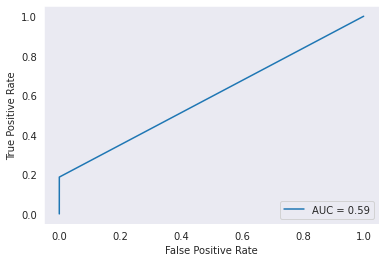

In [ ]:
fpr, tpr, _ = roc_curve(labels, pred)
roc_auc = metrics.auc(fpr, tpr)
roc_plot = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
roc_plot.plot()

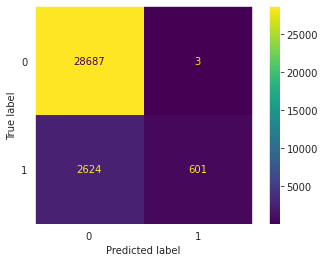

In [ ]:
cm = confusion_matrix(labels, pred)
cm_plot = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_plot.plot()

## Part8 : Modeling : Logistic Regression
- reference : https://medium.com/analytics-vidhya/applying-text-classification-using-logistic-regression-a-comparison-between-bow-and-tf-idf-1f1ed1b83640
- 6 models
  - unigram, bigram, trigram
  - TF-IDF & unigram, bigram, trigram

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
lr_test = pd.concat([val_org, test_org], axis=0)

### 1-1) Bag of Words (BoW)
- number of times word w appears in document d
- It only records how many times each word appears in the text and it does not give any importance to their order
- Each word count becomes a dimension for that specific word

In [ ]:
cv = CountVectorizer(tokenizer=lambda doc: doc)
X_train = cv.fit_transform(train_org['comment_text'])
X_test = cv.transform(lr_test['comment_text'])

words = cv.get_feature_names()
len(words)

1424

### 1-2) Bag of n-Grams
- It is an extension of Bag-of-Words
- It represents n-grams as a sequence of n tokens
- a word is 1-gram (unigram), two words are 2-gram (bigram), etc.
- It retains the original sequence of the text more than the Bag of Words representation
- However, it has a very high computational cost, because theoretically k unique words can mean k^2 unique bigrams

In [ ]:
bigram = CountVectorizer(tokenizer=lambda doc: doc, ngram_range=[2,2])
X_bi = bigram.fit_transform(train_org['comment_text'])
X_bi_test = bigram.transform(lr_test['comment_text'])

trigram = CountVectorizer(tokenizer=lambda doc: doc, ngram_range=[3,3])
X_tri = trigram.fit_transform(train_org['comment_text'])
X_tri_test = trigram.transform(lr_test['comment_text'])

### 2) Tf-idf

In [ ]:
tfidf = text.TfidfTransformer(norm=None)

X_bow_ti = tfidf.fit_transform(X_train)
X_bow_ti_test = tfidf.transform(X_test)

X_bi_ti = tfidf.fit_transform(X_bi)
X_bi_ti_test = tfidf.fit_transform(X_bi_test)

X_tri_ti = tfidf.fit_transform(X_tri)
X_tri_ti_test = tfidf.fit_transform(X_tri_test)

### 3) Modeling

In [ ]:
def modeling(X_train, y_train, X_test, y_test, name):
    model = LogisticRegression(C=1.0).fit(X_train, y_train)
    score = model.score(X_test, y_test)
    print("Test score (", name, ") : ", score)

    pred = model.predict(X_test)

    print('Accuracy: ', round(accuracy_score(y_test, pred)*100, 2), '%')
    print('F1-Score: ', round(f1_score(y_test, pred)*100, 2), '%')

    fpr, tpr, _ = roc_curve(y_test, pred)
    roc_auc = metrics.auc(fpr, tpr)
    roc_plot = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
    roc_plot.plot()

    cm = confusion_matrix(y_test, pred)
    cm_plot = ConfusionMatrixDisplay(confusion_matrix=cm)
    cm_plot.plot()

In [ ]:
y_train = train_org['toxic']
y_test = lr_test['toxic']

Without tf-idf

Test score ( bow ) :  0.9010809963966787
Accuracy:  90.11 %
F1-Score:  6.9 %


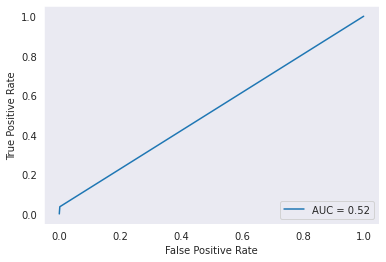

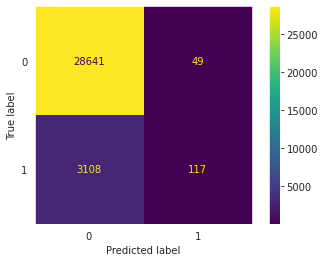

In [ ]:
modeling(X_train, y_train, X_test, y_test, 'bow')

Test score ( bigram ) :  0.9257715807613974
Accuracy:  92.58 %
F1-Score:  49.56 %


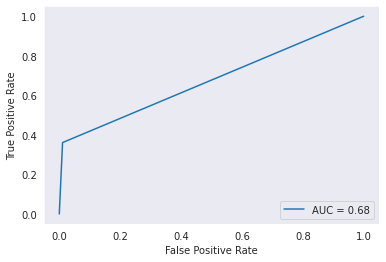

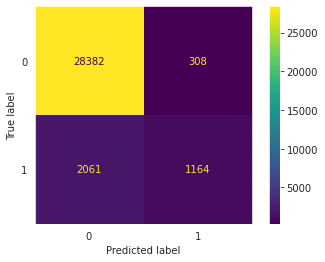

In [ ]:
modeling(X_bi, y_train, X_bi_test, y_test, 'bigram')

Test score ( trigram ) :  0.9511828293905688
Accuracy:  95.12 %
F1-Score:  72.89 %


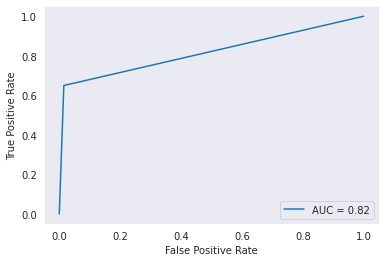

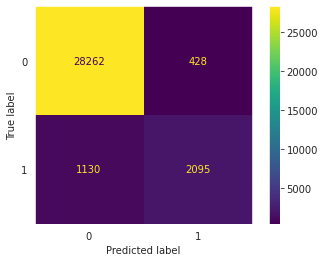

In [ ]:
modeling(X_tri, y_train, X_tri_test, y_test, 'trigram')

With tf-idf

Test score ( bow ) :  0.9009869967100109
Accuracy:  90.1 %
F1-Score:  6.89 %


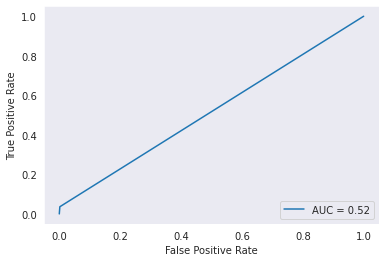

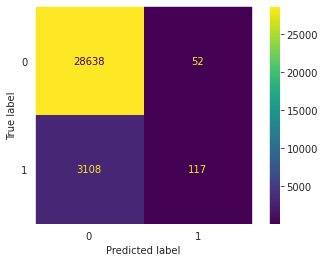

In [ ]:
modeling(X_bow_ti, y_train, X_bow_ti_test, y_test, 'bow')

Test score ( bigram ) :  0.9261789127369575
Accuracy:  92.62 %
F1-Score:  50.0 %


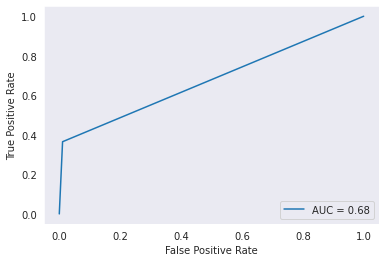

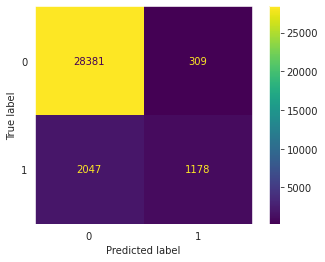

In [ ]:
modeling(X_bi_ti, y_train, X_bi_ti_test, y_test, 'bigram')

Test score ( bigram ) :  0.9505561648127839
Accuracy:  95.06 %
F1-Score:  73.05 %


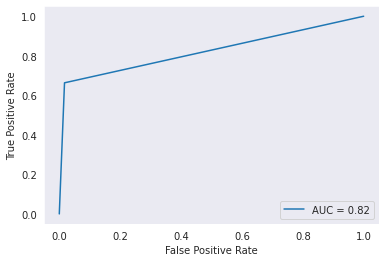

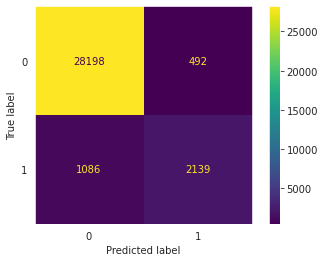

In [ ]:
modeling(X_tri_ti, y_train, X_tri_ti_test, y_test, 'bigram')

## Part9 : Modeling : RNN
- Reference : https://www.tensorflow.org/text/tutorials/text_classification_rnn

In [43]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [44]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


#### Check whether it works good
- The result should be the same (without padding vs with padding)

In [45]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print('without padding : ', predictions[0])

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print('with padding : ', predictions[0])

without padding :  [0.00084354]
with padding :  [0.00084354]


In [46]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=['accuracy'])

In [47]:
history = model.fit(
    train_df,
    epochs=5,
    validation_data=val_df,
    validation_steps=30)

Epoch 1/5
3990/3990 [==============================] - 146s 35ms/step - loss: 0.1711 - accuracy: 0.9394 - val_loss: 0.1311 - val_accuracy: 0.9563
Epoch 2/5
3990/3990 [==============================] - 131s 33ms/step - loss: 0.0844 - accuracy: 0.9681 - val_loss: 0.1498 - val_accuracy: 0.9500
Epoch 3/5
3990/3990 [==============================] - 134s 34ms/step - loss: 0.0659 - accuracy: 0.9751 - val_loss: 0.1482 - val_accuracy: 0.9552
Epoch 4/5
3990/3990 [==============================] - 131s 33ms/step - loss: 0.0539 - accuracy: 0.9798 - val_loss: 0.1703 - val_accuracy: 0.9563
Epoch 5/5
3990/3990 [==============================] - 133s 33ms/step - loss: 0.0446 - accuracy: 0.9839 - val_loss: 0.1920 - val_accuracy: 0.9531


In [49]:
model_fit =  model.fit(
    train_df,
    epochs=3,
    validation_data=val_df,
    validation_steps=30)

Epoch 1/3
3990/3990 [==============================] - 138s 35ms/step - loss: 0.0369 - accuracy: 0.9871 - val_loss: 0.2331 - val_accuracy: 0.9479
Epoch 2/3
3990/3990 [==============================] - 133s 33ms/step - loss: 0.0304 - accuracy: 0.9897 - val_loss: 0.2879 - val_accuracy: 0.9375
Epoch 3/3
3990/3990 [==============================] - 140s 35ms/step - loss: 0.0249 - accuracy: 0.9917 - val_loss: 0.2495 - val_accuracy: 0.9490


In [50]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 64)          4851328   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,925,697
Trainable params: 4,925,697
Non-

### Save Model

In [51]:
model_path = "./drive/MyDrive/CS7641ML_teamproject/Yuna-lstm/lstm_basic"

In [52]:
model.save(model_path)

In [56]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

(0.0, 0.1993937000632286)

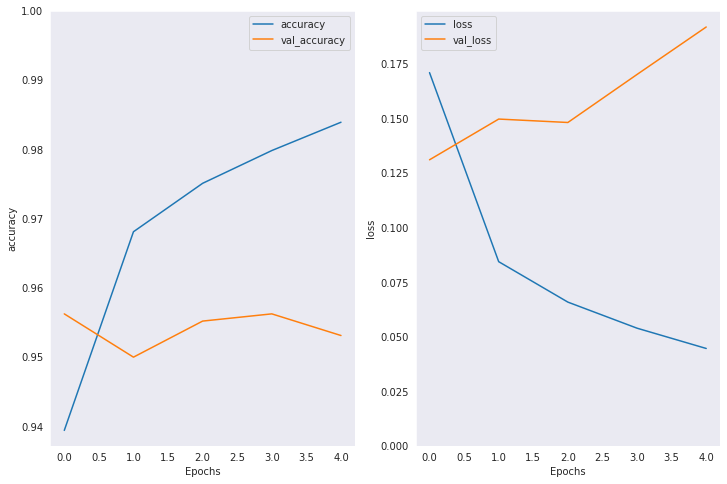

In [58]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

## Part10 : Modeling : LSTM (>= 2 layers)

In [60]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [61]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=['accuracy'])

In [62]:
history = model.fit(
    train_df,
    epochs=3,
    validation_data=val_df,
    validation_steps=30)

Epoch 1/3
3990/3990 [==============================] - 281s 64ms/step - loss: 0.1752 - accuracy: 0.9417 - val_loss: 0.1516 - val_accuracy: 0.9448
Epoch 2/3
3990/3990 [==============================] - 249s 62ms/step - loss: 0.0893 - accuracy: 0.9667 - val_loss: 0.1583 - val_accuracy: 0.9479
Epoch 3/3
3990/3990 [==============================] - 250s 63ms/step - loss: 0.0715 - accuracy: 0.9722 - val_loss: 0.1500 - val_accuracy: 0.9542


In [63]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding_1 (Embedding)     (None, None, 64)          4851328   
                                                                 
 bidirectional_1 (Bidirectio  (None, None, 128)        66048     
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                      

In [ ]:
model_path = "./drive/MyDrive/CS7641ML_teamproject/lstm_2layers"
model.save(model_path)

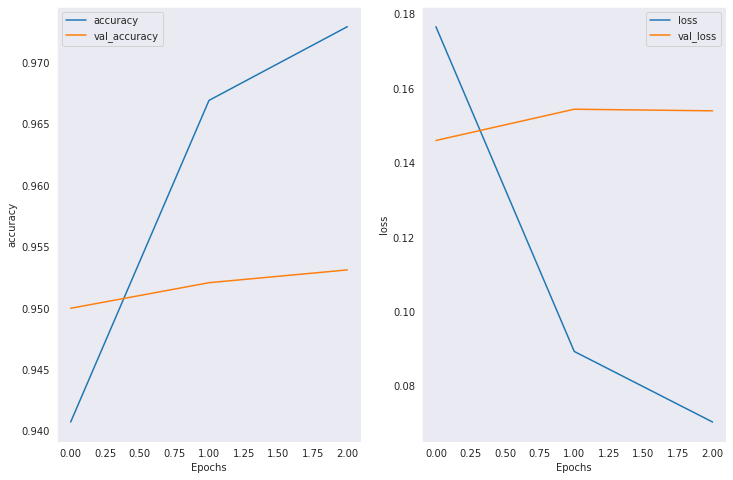

In [ ]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

## Part11 : Evaluate LSTM

In [59]:
model_path = "./drive/MyDrive/CS7641ML_teamproject/Yuna-lstm"

In [ ]:
lstm_basic = tf.keras.models.load_model(model_path+"/lstm_basic")
lstm_layers = tf.keras.models.load_model(model_path+"/lstm_2layers")

### Evaluation

In [ ]:
test_loss, test_acc = lstm_basic.evaluate(test_df)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

499/499 [==============================] - 13s 14ms/step - loss: 0.1317 - accuracy: 0.9604
Test Loss: 0.1317049264907837
Test Accuracy: 0.9603960514068604


In [ ]:
test_loss, test_acc = lstm_layers.evaluate(test_df)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

499/499 [==============================] - 17s 24ms/step - loss: 0.1122 - accuracy: 0.9625
Test Loss: 0.11215995997190475
Test Accuracy: 0.9625266194343567


- LSTM is not good at 'This is fucking good'
- BERT may perform better

In [ ]:
examples = [
    'I hate you Bitch',
    'Fuck you',
    'Damn! I like your comment',
    'Okay I think it is good',
    'This is fucking good!'
]

print('basic')
for sentence in examples:
    pred = lstm_basic.predict(np.array([sentence]))
    pred = np.squeeze(np.array(tf.sigmoid(pred)))
    print('input : ', sentence, ' pred : ', pred)

print()
print('layers')
for sentence in examples:
    pred = lstm_layers.predict(np.array([sentence]))
    pred = np.squeeze(np.array(tf.sigmoid(pred)))
    print('input : ', sentence, ' pred : ', pred)

basic
input :  I hate you Bitch  pred :  0.99989796
input :  Fuck you  pred :  0.99978477
input :  Damn! I like your comment  pred :  0.8911738
input :  Okay I think it is good  pred :  0.00089560496
input :  This is fucking good!  pred :  0.99966586

layers
input :  I hate you Bitch  pred :  0.99609214
input :  Fuck you  pred :  0.9909162
input :  Damn! I like your comment  pred :  0.8644287
input :  Okay I think it is good  pred :  0.0018025922
input :  This is fucking good!  pred :  0.9954436


In [ ]:
def eval(model, data):

    logits = model.predict(data['comment_text'])
    probs = np.squeeze(np.array(tf.sigmoid(logits)))
    pred = (probs > .5).astype(int)
    
    labels = data['toxic']

    fpr, tpr, _ = roc_curve(labels, probs)
    roc_auc = metrics.auc(fpr, tpr)
    roc_plot = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
    roc_plot.plot()
    # plt.show()

    cm = confusion_matrix(labels, pred)
    cm_plot = ConfusionMatrixDisplay(confusion_matrix=cm)
    cm_plot.plot()
    # plt.show()

    print('Accuracy: ', round(accuracy_score(labels, pred)*100, 2), '%')
    print('F1-Score: ', round(f1_score(labels, pred)*100, 2), '%')

Accuracy:  95.9 %
F1-Score:  79.29 %
Accuracy:  95.73 %
F1-Score:  79.12 %


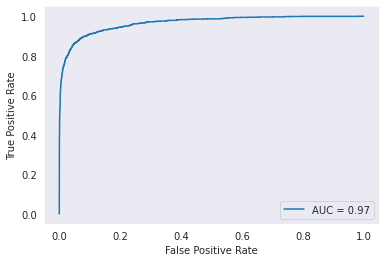

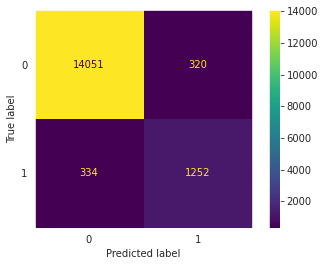

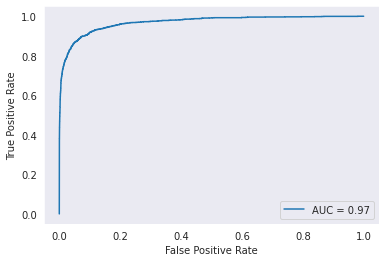

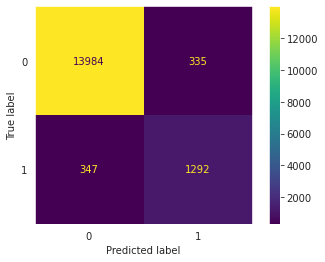

In [ ]:
eval(lstm_basic, val_org)
eval(lstm_basic, test_org)

Accuracy:  96.28 %
F1-Score:  80.75 %
Accuracy:  96.07 %
F1-Score:  80.5 %


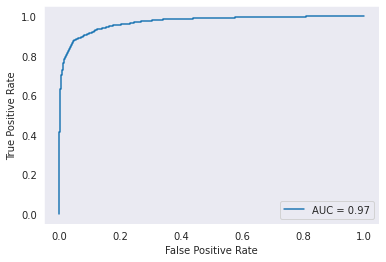

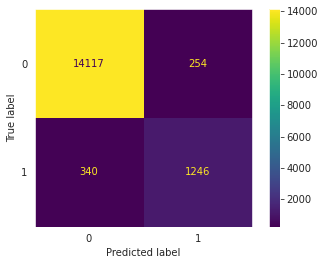

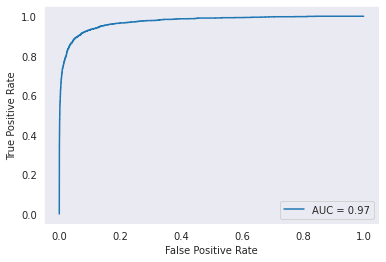

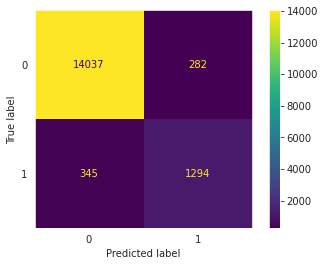

In [ ]:
eval(lstm_layers, val_org)
eval(lstm_layers, test_org)